<center><a target="_blank" href="http://www.propulsion.academy"><img src="https://drive.google.com/uc?id=1MleNI0rcICpvrGd7SdYuQz7dn8NlAlEc" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>

_____

<center> <h1> Classification Models & Tackling Class Imbalance (Live coding) </h1> </center>

<p style="margin-bottom:1cm;"></p>

_____

<center>SIT Academy, 2022</center>

# Classification Models & Tackling Class Imbalance (Live coding)

__Topic covered__

- Logistic Regression
- Resampling using SMOTENC
- Resampling using RandomUnderSampler
- Class imbalance with class weights
- Classification Metrics
- ROC curve score and plotting

In [ ]:
!pip install imblearn --ignore-installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 5.1 MB/s 
     |████████████████████████████████| 15.7 MB 42.7 MB/s 
     |████████████████████████████████| 297 kB 45.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 199 kB 56.7 MB/s 
     |████████████████████████████████| 24.8 MB 1.4 MB/s 


# Load Dependencies

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC # for oversampling the minority class, i.e generating synthetic samples
from imblearn.under_sampling import RandomUnderSampler # for undersampling the majority class

__Helper function__

<span style="color:orange">**The helper function below will plot the ROC curve, calculate AUC for a base model and the AUC of our logistic regression model.**</span>

In [ ]:
def plot_roc(y_test, proba_preds):

    # create linear line
    base_probs = [0 for _ in range(len(y_test))]

    base_auc = roc_auc_score(y_test, base_probs)
    lr_auc = roc_auc_score(y_test, proba_preds)

    # summarize scores
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, base_probs) 
    lr_fpr, lr_tpr, _ = roc_curve(y_test, proba_preds)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Loading Dataset


We can pre-load the dataset with specific values (e.g., ?) depicting missing values (NaNs)



In [ ]:
# data_file = 'adult.csv'
orig_url = "https://drive.google.com/file/d/1Uw8vaoygdIiTC1AkOPj_42kg8lwD9nUB/view?usp=sharing"
file_id = orig_url.split('/')[-2]
data_file='https://drive.google.com/uc?export=download&id=' + file_id
df = pd.read_csv(data_file, na_values=['?', ''])
# dropping unnecessary column
df = df.drop(columns='fnlwgt')
df.head(10)

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,NaN,HS-grad,9,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   education        48842 non-null  object
 3   educational-num  48842 non-null  int64 
 4   marital-status   48842 non-null  object
 5   occupation       46033 non-null  object
 6   relationship     48842 non-null  object
 7   race             48842 non-null  object
 8   gender           48842 non-null  object
 9   capital-gain     48842 non-null  int64 
 10  capital-loss     48842 non-null  int64 
 11  hours-per-week   48842 non-null  int64 
 12  native-country   47985 non-null  object
 13  income           48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


# Training a Logistic Regression Model with Pipelines

We will show all the major steps needed to train your first classification model using sklearn pipelines which often makes the code more concise and you need lesser lines of code.

## Split Dataset into train and test Datsets

We split the dataset into a standard 70:30 train-test split using stratified sampling to keep the distributions of classes similar in train and test datasets

In [ ]:
X = df.drop(columns=['income'])
y = df['income']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape

((34189, 13), (14653, 13))

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34189 entries, 38865 to 4610
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              34189 non-null  int64 
 1   workclass        32263 non-null  object
 2   education        34189 non-null  object
 3   educational-num  34189 non-null  int64 
 4   marital-status   34189 non-null  object
 5   occupation       32253 non-null  object
 6   relationship     34189 non-null  object
 7   race             34189 non-null  object
 8   gender           34189 non-null  object
 9   capital-gain     34189 non-null  int64 
 10  capital-loss     34189 non-null  int64 
 11  hours-per-week   34189 non-null  int64 
 12  native-country   33599 non-null  object
dtypes: int64(5), object(8)
memory usage: 3.7+ MB


<span style="color:orange"> **We first want to check how balanced our data is. We can use the buildin function 'value_counts' to do this.**</span>

In [ ]:
y_train.value_counts()

<=50K    26008
>50K      8181
Name: income, dtype: int64

In [ ]:
y_test.value_counts()

<=50K    11147
>50K      3506
Name: income, dtype: int64

In [ ]:
y_train.value_counts(normalize=True)

<=50K    0.760713
>50K     0.239287
Name: income, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

<=50K    0.760732
>50K     0.239268
Name: income, dtype: float64

## Separate categorical and numeric columns

We will need to treat these features separately just like before

In [ ]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

categorical_features, numeric_features

(['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'gender',
  'native-country'],
 ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

## Define Categorical Transformer Pipeline

Consists of the series of steps needed to tranform the categorical features. This includes: 

- Constant imputer to fill missing values
- One-hot encoder to get dummy variables

In [ ]:
categorical_transformer = Pipeline(steps=[
                                          ("cat_imputer", SimpleImputer(strategy='constant',
                                                                        fill_value='Not Available')),
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])
categorical_transformer

Pipeline(steps=[('cat_imputer',
                 SimpleImputer(fill_value='Not Available',
                               strategy='constant')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

## Define Numeric Transformer Pipeline

Consists of the series of steps needed to tranform the numeric features. This includes: 

- K-nearest neighbor imputer to fill missing values
- Standard Scaler to scale the numeric features 

In [ ]:
numeric_transformer = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5)),
                                      ("scaler", StandardScaler())
                                      ])

numeric_transformer

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler())])

## Define Column Transformer Pipeline for preprocessing

Consists of the series of steps needed to tranform all the features in sequence

- Numeric Transfomer defined earlier
- Categorical Transfomer defined earlier

In [ ]:
preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, 
                                                       numeric_features),
                                               ("cat", categorical_transformer, 
                                                       categorical_features)
                                               ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('knn_imputer', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'educational-num', 'capital-gain',
                                  'capital-loss', 'hours-per-week']),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='Not '
                                                                           'Available',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['workclass', 'education', 'marital-status',
                                  'occupation', 'relationshi

## Initialize Logistic Regression Model

In [ ]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model

LogisticRegression(random_state=42, solver='liblinear')

## Build Modeling Pipeline

Chains the following steps:

- Preprocessing pipeline steps defined earlier
- Logistic Regression model defined earlier

In [ ]:
pipeline_lr = Pipeline(steps=[
                              ("pre_process", preprocessor), 
                              ("model", lr_model)
                              ])
pipeline_lr

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Not '
                                                              

## Train and Evaluate Logistic Regression ML Pipeline

In [ ]:
pipeline_lr.fit(X_train, y_train)

y_pred = pipeline_lr.predict(X_test)

In [ ]:
pipeline_lr['model'].classes_

array(['<=50K', '>50K'], dtype=object)

In [ ]:
class_labels = pipeline_lr.named_steps['model'].classes_
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

,<=50K,>50K
<=50K,10428,719
>50K,1408,2098


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91     11147
        >50K       0.74      0.60      0.66      3506

    accuracy                           0.85     14653
   macro avg       0.81      0.77      0.79     14653
weighted avg       0.85      0.85      0.85     14653



# Training Logistic Regression Pipeline by handling Class Imbalance

<span style="color:orange"> **After we split our data into the training and testing sets, we ONLY resample the Training data to achieve a more balanced training for our model. Here we use 2 types of sampling methods:**</span>

<span style="color:orange"> **1. SMOTENC**</span> <br>
<span style="color:orange"> **2. RandomUnderSampler**</span>

In [ ]:
X = df.drop(columns=['income'])
y = df['income']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape

((34189, 13), (14653, 13))

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34189 entries, 38865 to 4610
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              34189 non-null  int64 
 1   workclass        32263 non-null  object
 2   education        34189 non-null  object
 3   educational-num  34189 non-null  int64 
 4   marital-status   34189 non-null  object
 5   occupation       32253 non-null  object
 6   relationship     34189 non-null  object
 7   race             34189 non-null  object
 8   gender           34189 non-null  object
 9   capital-gain     34189 non-null  int64 
 10  capital-loss     34189 non-null  int64 
 11  hours-per-week   34189 non-null  int64 
 12  native-country   33599 non-null  object
dtypes: int64(5), object(8)
memory usage: 3.7+ MB


In [ ]:
X_train.head(3)

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
38865,21,Private,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,60,United-States
17212,19,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,10,United-States
9312,32,NaN,HS-grad,9,Married-civ-spouse,NaN,Husband,Black,Male,0,0,45,United-States


__SMOTENC__

In [ ]:
categorical_feature_idxs = np.where(X_train.dtypes == "object")[0]
categorical_feature_idxs

array([ 1,  2,  4,  5,  6,  7,  8, 12])

In [ ]:
X_train.columns[categorical_feature_idxs]

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')

In [ ]:
smtnc = SMOTENC(categorical_features=categorical_feature_idxs) # initialize the SMOTEENC object
X_train_smote, y_train_smote = smtnc.fit_resample(X_train, y_train) # try to generate new samples

ValueError: ignored

In [ ]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
features = X_train.columns

In [ ]:
categorical_features, numeric_features

(['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'gender',
  'native-country'],
 ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

In [ ]:
categorical_imputer = Pipeline(steps=[
                              ("cat_imputer", SimpleImputer(strategy='constant',
                                                            fill_value='Not Available'))
                              ])
numeric_imputer = Pipeline(steps=[
                                  ("knn_imputer", KNNImputer(n_neighbors=5))
                                  ])

imputer = ColumnTransformer(transformers=[
                                          ("num", numeric_imputer, 
                                                  numeric_features),
                                          ("cat", categorical_imputer, 
                                                  categorical_features)
                                          ])
imputer

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('knn_imputer',
                                                  KNNImputer())]),
                                 ['age', 'educational-num', 'capital-gain',
                                  'capital-loss', 'hours-per-week']),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='Not '
                                                                           'Available',
                                                                strategy='constant'))]),
                                 ['workclass', 'education', 'marital-status',
                                  'occupation', 'relationship', 'race',
                                  'gender', 'native-country'])])

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34189 entries, 38865 to 4610
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              34189 non-null  int64 
 1   workclass        32263 non-null  object
 2   education        34189 non-null  object
 3   educational-num  34189 non-null  int64 
 4   marital-status   34189 non-null  object
 5   occupation       32253 non-null  object
 6   relationship     34189 non-null  object
 7   race             34189 non-null  object
 8   gender           34189 non-null  object
 9   capital-gain     34189 non-null  int64 
 10  capital-loss     34189 non-null  int64 
 11  hours-per-week   34189 non-null  int64 
 12  native-country   33599 non-null  object
dtypes: int64(5), object(8)
memory usage: 3.7+ MB


In [ ]:
X_train = imputer.fit_transform(X_train, )
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train, columns=numeric_features+categorical_features)
X_train[numeric_features] = X_train[numeric_features].astype('int64')
X_train = X_train[features]

X_test = pd.DataFrame(X_test, columns=numeric_features+categorical_features)
X_test[numeric_features] = X_test[numeric_features].astype('int64')
X_test = X_test[features]

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34189 entries, 0 to 34188
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              34189 non-null  int64 
 1   workclass        34189 non-null  object
 2   education        34189 non-null  object
 3   educational-num  34189 non-null  int64 
 4   marital-status   34189 non-null  object
 5   occupation       34189 non-null  object
 6   relationship     34189 non-null  object
 7   race             34189 non-null  object
 8   gender           34189 non-null  object
 9   capital-gain     34189 non-null  int64 
 10  capital-loss     34189 non-null  int64 
 11  hours-per-week   34189 non-null  int64 
 12  native-country   34189 non-null  object
dtypes: int64(5), object(8)
memory usage: 3.4+ MB


In [ ]:
categorical_feature_idxs

array([ 1,  2,  4,  5,  6,  7,  8, 12])

In [ ]:
smtnc = SMOTENC(categorical_features=categorical_feature_idxs)
X_train_smote, y_train_smote = smtnc.fit_resample(X_train, y_train)

In [ ]:
X_train_smote = pd.DataFrame(X_train_smote, columns=features)
X_train_smote.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,21,Private,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,60,United-States
1,19,Not Available,Some-college,10,Never-married,Not Available,Own-child,White,Female,0,0,10,United-States
2,32,Not Available,HS-grad,9,Married-civ-spouse,Not Available,Husband,Black,Male,0,0,45,United-States
3,35,Private,Bachelors,13,Divorced,Transport-moving,Not-in-family,White,Male,0,0,40,United-States
4,21,Private,Assoc-acdm,12,Never-married,Adm-clerical,Own-child,White,Male,0,0,35,United-States


In [ ]:
y_train.value_counts()

<=50K    26008
>50K      8181
Name: income, dtype: int64

In [ ]:
y_train_smote.value_counts()

<=50K    26008
>50K     26008
Name: income, dtype: int64

__Resampling RandomUnderSampler__

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [ ]:
y_train_rus.value_counts()

<=50K    8181
>50K     8181
Name: income, dtype: int64

In [ ]:
X_train_rus = pd.DataFrame(X_train_rus, columns=features)
X_train_rus.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,32,Self-emp-not-inc,Some-college,10,Never-married,Craft-repair,Own-child,White,Male,0,1980,80,United-States
1,20,Not Available,HS-grad,9,Never-married,Not Available,Not-in-family,White,Female,0,0,40,United-States
2,31,Private,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,50,United-States
3,31,Local-gov,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States
4,29,Private,Assoc-voc,11,Separated,Adm-clerical,Unmarried,White,Female,0,0,40,United-States


__Create Pipeline__



In [ ]:
categorical_transformer = Pipeline(steps=[
                                          ("cat_imputer", SimpleImputer(strategy='constant',
                                                                        fill_value='Not Available')),
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])

numeric_transformer = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5)),
                                      ("scaler", StandardScaler())
                                      ])

preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, 
                                                       numeric_features),
                                               ("cat", categorical_transformer, 
                                                       categorical_features)
                                               ])

lr_model = LogisticRegression(random_state=42, solver='liblinear')

In [ ]:
pipeline_l_regr = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", lr_model)])

# Recap: No Resampling

<span style="color:orange"> **Let's first run a model without resampling the data.**</span> <br>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape

((34189, 13), (14653, 13))

In [ ]:
pipeline_l_regr.fit(X_train, y_train)
pred_no_resample = pipeline_l_regr.predict(X_test)

<span style="color:orange"> **To evaluate our model, we do:**</span> 

<span style="color:green"> *1. Confusion Matrix*</span> <br>
<span style="color:green"> *2. Classification report*</span> <br>
<span style="color:green"> *3. ROC and AUC*</span> <br>

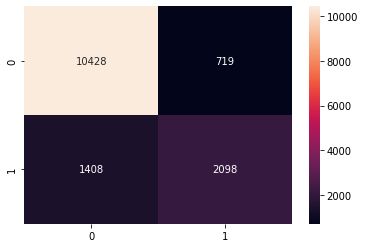

In [ ]:
cf = confusion_matrix(y_test, pred_no_resample)
sns.heatmap(cf, annot=True, fmt='.0f');

In [ ]:
print(classification_report(y_test, pred_no_resample))

              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91     11147
        >50K       0.74      0.60      0.66      3506

    accuracy                           0.85     14653
   macro avg       0.81      0.77      0.79     14653
weighted avg       0.85      0.85      0.85     14653



In [ ]:
pipeline_l_regr.classes_

array(['<=50K', '>50K'], dtype=object)

In [ ]:
y_test[:10]

39432    <=50K
25976    <=50K
3591     <=50K
25158    <=50K
6288     <=50K
37022    <=50K
24977     >50K
11883    <=50K
44211    <=50K
6064     <=50K
Name: income, dtype: object

In [ ]:
y_test_encoded = [0 if item == '<=50K' else 1 for item in y_test]
y_test_encoded[:10]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [ ]:
pipeline_l_regr['estimator'].classes_

array(['<=50K', '>50K'], dtype=object)

In [ ]:
pipeline_l_regr.predict(X_test)[:10]

array(['>50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '>50K',
       '<=50K', '<=50K', '<=50K'], dtype=object)

In [ ]:
pipeline_l_regr.predict_proba(X_test)[:10]

array([[0.45416257, 0.54583743],
       [0.64241209, 0.35758791],
       [0.98306298, 0.01693702],
       [0.98745261, 0.01254739],
       [0.99509326, 0.00490674],
       [0.94494697, 0.05505303],
       [0.37612182, 0.62387818],
       [0.70188468, 0.29811532],
       [0.96711526, 0.03288474],
       [0.99759752, 0.00240248]])

Logistic: ROC AUC=0.907


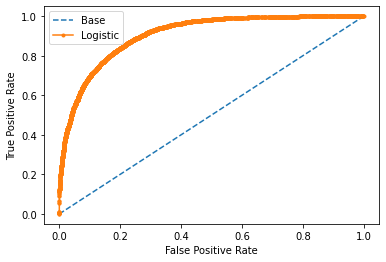

In [ ]:
proba_pred_no_resampling = pipeline_l_regr.predict_proba(X_test)[:, 1]
plot_roc(y_test_encoded, proba_pred_no_resampling)

# Tackling Imbalance with Class weights

In [ ]:
y_train.value_counts()

<=50K    26008
>50K      8181
Name: income, dtype: int64

In [ ]:
l_regr2 = LogisticRegression(class_weight={'<=50K': 1, 
                                           '>50K': 3}, 
                             random_state=42,
                             solver='liblinear'
                             )
pipeline_l_regr2 = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", l_regr2)])

In [ ]:
pipeline_l_regr2.fit(X_train, y_train)
pred_no_resample2 = pipeline_l_regr2.predict(X_test)

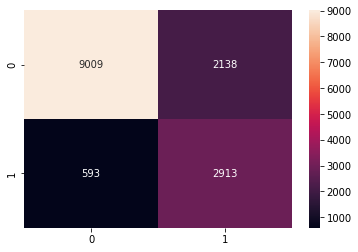

In [ ]:
cf = confusion_matrix(y_test, pred_no_resample2)
sns.heatmap(cf, annot=True, fmt='.0f');

In [ ]:
print(classification_report(y_test, pred_no_resample2))

              precision    recall  f1-score   support

       <=50K       0.94      0.81      0.87     11147
        >50K       0.58      0.83      0.68      3506

    accuracy                           0.81     14653
   macro avg       0.76      0.82      0.77     14653
weighted avg       0.85      0.81      0.82     14653



Logistic: ROC AUC=0.907


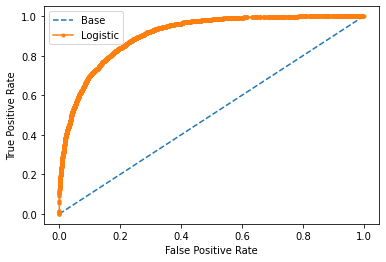

In [ ]:
proba_pred_class_wts = pipeline_l_regr2.predict_proba(X_test)[:, 1]
plot_roc(y_test_encoded, proba_pred_class_wts)

# Tackling Imbalance with SMOTE resampling

In [ ]:
pipeline_l_regr

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Not '
                                                          

In [ ]:
y_train_smote.value_counts()

<=50K    26008
>50K     26008
Name: income, dtype: int64

In [ ]:
pipeline_l_regr.fit(X_train_smote, y_train_smote)
pred_smote = pipeline_l_regr.predict(X_test)

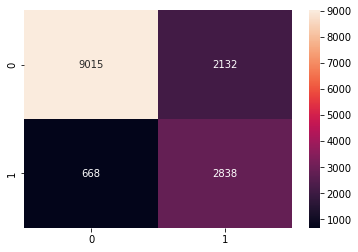

In [ ]:
cf = confusion_matrix(y_test, pred_smote)
sns.heatmap(cf, annot=True, fmt='.0f');

In [ ]:
print(classification_report(y_test, pred_smote))

              precision    recall  f1-score   support

       <=50K       0.93      0.81      0.87     11147
        >50K       0.57      0.81      0.67      3506

    accuracy                           0.81     14653
   macro avg       0.75      0.81      0.77     14653
weighted avg       0.84      0.81      0.82     14653



Logistic: ROC AUC=0.901


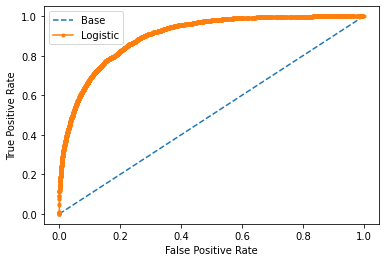

In [ ]:
proba_pred_smote = pipeline_l_regr.predict_proba(X_test)[:, 1]
plot_roc(y_test_encoded, proba_pred_smote)

# Tackling Imbalance with RandomUnderSampler

In [ ]:
y_train_rus.value_counts()

<=50K    8181
>50K     8181
Name: income, dtype: int64

In [ ]:
pipeline_l_regr.fit(X_train_rus, y_train_rus)
pred_rus = pipeline_l_regr.predict(X_test)

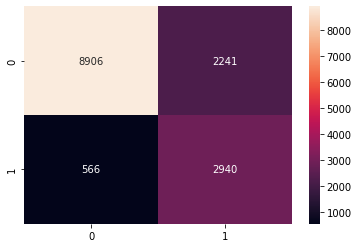

In [ ]:
cf = confusion_matrix(y_test, pred_rus)
sns.heatmap(cf, annot=True, fmt='.0f');

In [ ]:
print(classification_report(y_test, pred_rus))

              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86     11147
        >50K       0.57      0.84      0.68      3506

    accuracy                           0.81     14653
   macro avg       0.75      0.82      0.77     14653
weighted avg       0.85      0.81      0.82     14653



Logistic: ROC AUC=0.906


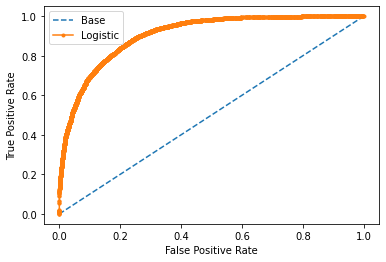

In [ ]:
prob_pred_rus = pipeline_l_regr.predict_proba(X_test)[:, 1]
plot_roc(y_test_encoded, prob_pred_rus)